# Import Libraries 

In [42]:
import os
import numpy as np
from numpy import save
from numpy import asarray
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
import pickle as pkl
import tensorflow as tf

from tensorflow import keras as K
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import DenseNet121 
from tensorflow.keras.applications import EfficientNetB0

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
## Load data using pickle
def unloadPickle(file):
    with open(file, 'rb') as f:
        temp =  pkl.load(f, encoding='latin1')
    return temp

## Extract train and test data and reshape images to (32, 32, 3)
def extractData(dataPath, dataStr):
    
    if dataStr == '\data_batch_':
        X_train = []
        y_train = []

        for i in range(1, 6):
            filePath = dataPath + dataStr + str(i)
            file = unloadPickle(filePath)
            file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
            X_train.append(file['data'])
            y_train.append(file['labels'])
            
        metaFile = unloadPickle(os.path.join(dataPath,'batches.meta'))
        labelNames = metaFile['label_names']
        
        return X_train, y_train, labelNames
    
    elif dataStr == 'test_batch':    
        
        filePath = os.path.join(dataPath, dataStr)
        file = unloadPickle(filePath)
        file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        X_test = file['data']
        y_test = file['labels']
    
        return X_test, y_test

## Display the statistics of the data and display the image based on the batch and sample image    
def displayStats(dataPath, dataStr, batch_id, sample_id):
    
    X, y, labelNames = extractData(dataPath, dataStr)
    
    features = []
    labels = []
    
    print('No. of batches : {}'.format(len(X)))
    print('No. of samples in each batch : {}'.format(len(X[batch_id])))
    print('Shape of each sample : {}'.format(X[batch_id - 1][sample_id].shape))
    print('\nStats of batch {}'.format(batch_id))
    print('\nCount of each label in batch {} : '.format(batch_id))
    
    label_counts = dict(zip(*np.unique(y[batch_id - 1], return_counts=True)))
    
    for key, value in label_counts.items():
        print('No. of {} images : {}'.format((labelNames[key]).upper(), value))
    
    sample_label = y[batch_id - 1][sample_id]
    print('\nSample Id : {}, Image name : {}'.format(sample_id, (labelNames[sample_label]).upper()))
    sample_image = X[batch_id - 1][sample_id]
    plt.imshow(sample_image)

## One hot encode the labels
def oneHotEncode(labels):
    
    x = np.zeros((len(labels), 10))
    for i, j in enumerate(labels):
        x[i][j] = 1
    
    return x

## Dump the train or test data in pickle files
def saveData(batch_features, batch_labels, filename):
    
    pkl.dump((batch_features, batch_labels), open(filename, 'wb'))
    
def schedulerLr(epoch, lr):
    if epoch < lr:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

## Display Train vs Validation loss and accuracy graphs    
def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']
    train_acuracy = model.history['accuracy']
    validation_accuracy = model.history['val_accuracy']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.plot(r_ep, train_acuracy)
    plt.plot(r_ep, validation_accuracy)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')

# Load Dataset 

In [2]:
os.chdir("../..")
dataPath = os.path.join(os.getcwd(), 'ImageClassification\\archive\cifar-10-batches-py')

No. of batches : 5
No. of samples in each batch : 10000
Shape of each sample : (32, 32, 3)

Stats of batch 1

Count of each label in batch 1 : 
No. of AIRPLANE images : 1005
No. of AUTOMOBILE images : 974
No. of BIRD images : 1032
No. of CAT images : 1016
No. of DEER images : 999
No. of DOG images : 937
No. of FROG images : 1030
No. of HORSE images : 1001
No. of SHIP images : 1025
No. of TRUCK images : 981

Sample Id : 123, Image name : BIRD


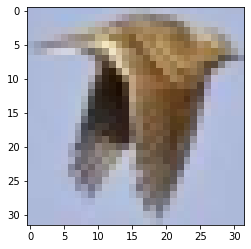

In [5]:
trainStr = '\data_batch_'
testStr = 'test_batch'

displayStats(dataPath, trainStr, 1, 123)

In [5]:
feat, lbl, labelNames = extractData(dataPath, 
                                    trainStr)

# Pre-processing

In [16]:
batch_ids = [1, 2, 3, 4, 5]
train_feat, train_lbl = [], []
for b_id in batch_ids:
    temp_batch = []
    for idx, img in enumerate(feat[i-1]):
        temp_batch.append(feat[b_id-1][idx] / 255.0)
    train_feat.append(asarray(temp_batch)) 
    train_lbl.append(oneHotEncode(lbl[b_id-1]))
    
    saveData(train_feat[b_id-1], 
             train_lbl[b_id-1], 
             os.path.join(dataPath, 
                          'prcsd_batch_' + str(b_id) + '.pkl'))

In [7]:
X, y = extractData(dataPath, testStr)
X_test, y_test = [], []
for idx, img in enumerate(X):
    X[idx] = X[idx].astype('float32')
    X_test.append(X[idx] / 255.0)

X_test = asarray(X_test)    
y_test = oneHotEncode(y)
saveData(X_test, 
         y_test, 
         os.path.join(dataPath, 
                      'prcsd_test_batch.pkl'))

# Model Generation

### Loading saved processed data 

In [8]:
train_features = []
train_labels = []
batch_ids = [1, 2, 3, 4, 5]
for b_id in batch_ids:
    path = os.path.join(dataPath, 'prcsd_batch_' + str(b_id) + '.pkl')
    temp_batch = unloadPickle(path)
    train_features.append(temp_batch[0]) 
    train_labels.append(temp_batch[1])

In [9]:
X_train_features, y_train_labels = np.concatenate(train_features, 
                                                  axis = 0), np.concatenate(train_labels, 
                                                                            axis = 0)

In [10]:
test_path = os.path.join(dataPath, 'prcsd_test_batch.pkl')
X_test, y_test = unloadPickle(test_path)

In [15]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train_features, 
                                                                  y_train_labels, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

### Resize the images to associate with the pre-trained models  

In [38]:
imgRows = 224
imgCols = 224

## Input tensor
inputs = Input(shape=(X_train_features[0].shape))

## Resize the image to dimensions 224 x 224
# upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 
#                                                              imgRows, 
#                                                              imgCols, 
#                                                              method=tf.image.ResizeMethod.BILINEAR))(inputs)

### VGG16 

In [59]:
def model_CustomVGG16(inputImg):
    
    model = VGG16(include_top=False, 
                  weights='imagenet', 
                  input_tensor=inputs, 
                  input_shape=(X_train_features[0].shape))
    
    for layer in model.layers[:15]:
        layer.trainable = False
    
    return model.output
    
def last_Layer(input_layer, 
               dropout_rate, 
               labels):
    
    flatten = Flatten()(input_layer)
    dense_layer1 = Dense(512, activation='relu')(flatten)
    batchNorm_layer1 = BatchNormalization()(dense_layer1)
    #dropout_layer1 = Dropout(dropout_rate)(batchNorm_layer1)
    
    dense_layer2 = Dense(256, activation='relu')(batchNorm_layer1)
    batchNorm_layer2 = BatchNormalization()(dense_layer2)
    #dropout_layer2 = Dropout(dropout_rate)(batchNorm_layer2)
    
    dense_layer3 = Dense(128, activation='relu')(batchNorm_layer2)
    batchNorm_layer3 = BatchNormalization()(dense_layer3)
    #dropout_layer3 = Dropout(dropout_rate)(batchNorm_layer3)
    
    dense_layer4 = Dense(64, activation='relu')(batchNorm_layer3)
    batchNorm_layer4 = BatchNormalization()(dense_layer4)
    #dropout_layer4 = Dropout(dropout_rate)(batchNorm_layer4)
    
    final_layer = Dense(labels, activation='softmax')(batchNorm_layer4)
    
    return final_layer

In [62]:
callback = tf.keras.callbacks.LearningRateScheduler(schedulerLr)

In [63]:
learning_rate = 0.001
dropout_rate = 0.2
num_epoch = 20
labels = len(y_train[0])
batch_size = 128

vgg16_output = model_CustomVGG16(inputs)
final = last_Layer(vgg16_output, 
                   dropout_rate, 
                   labels)
model = Model([inputs], 
              final)

opt = Adam(learning_rate)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(os.path.join(dataPath, 
                                                'VGG16_Model.h5'), 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_only_best=True)
# early_stopping = EarlyStopping(monitor='val_accuracy', 
#                                verbose=1, 
#                                patience=5)

vgg16_model = model.fit(X_train, 
                        y_train, 
                        batch_size,
                        num_epoch,
                        callbacks=[model_checkpoint, 
                                   callback], 
                        validation_data=(X_train_val, 
                                         y_train_val))

Epoch 1/20
313/313 [==============================] - ETA: 0s - loss: 1.1563 - accuracy: 0.5992
Epoch 1: saving model to D:\Competetions\Kaggle\ImageClassification\archive\cifar-10-batches-py\VGG16_Model.h5
313/313 [==============================] - 125s 396ms/step - loss: 1.1563 - accuracy: 0.5992 - val_loss: 3.4056 - val_accuracy: 0.3197 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - ETA: 0s - loss: 0.8536 - accuracy: 0.7052
Epoch 2: saving model to D:\Competetions\Kaggle\ImageClassification\archive\cifar-10-batches-py\VGG16_Model.h5
313/313 [==============================] - 123s 394ms/step - loss: 0.8536 - accuracy: 0.7052 - val_loss: 1.0675 - val_accuracy: 0.6471 - lr: 9.0484e-04
Epoch 3/20
313/313 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.7377
Epoch 3: saving model to D:\Competetions\Kaggle\ImageClassification\archive\cifar-10-batches-py\VGG16_Model.h5
313/313 [==============================] - 124s 397ms/step - loss: 0.7542 - acc

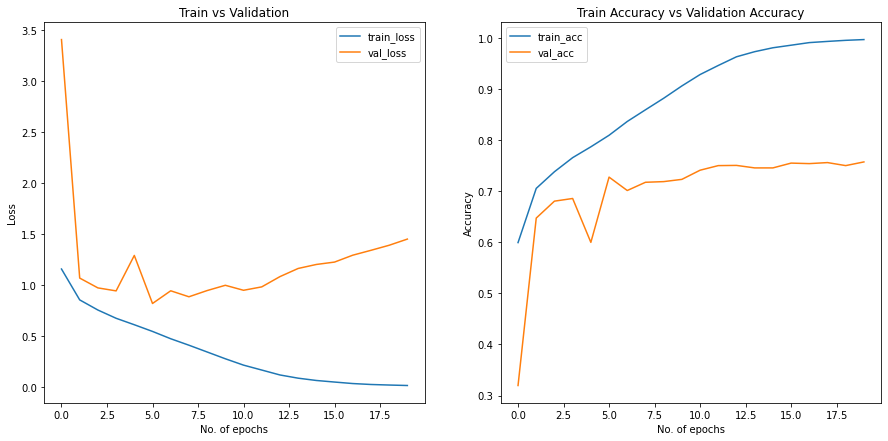

In [65]:
metrics_graph(vgg16_model, num_epoch)